In [3]:
import pandas as pd
import gzip as gz
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [4]:
imdb = 'data/im.db.zip'
with ZipFile(imdb, 'r') as zip:
    zip.extractall('data/imdb_unzipped')

conn = sqlite3.connect('data/imdb_unzipped/im.db')
        
q = """
SELECT *
FROM sqlite_master
"""
pd.read_sql(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [5]:
# create dataframe for principals work
q = """
SELECT pr.movie_id, pr.person_id, pr.category, p.primary_name, p.death_year, m.primary_title AS 'Movie Title'
FROM principals pr
    JOIN persons p
        USING(person_id)
    JOIN movie_basics m
        USING(movie_id)
"""
principals_df = pd.read_sql(q, conn)

In [6]:
#Move alive principals into a new DF

#Replace Null to give value (0) for entries to keep
principals_df['death_year'].fillna(0, inplace=True)

# Remove rows without valid death year
alive_ppl = principals_df[principals_df['death_year'] == 0]

# Create cleaned DF
alive_ppl.drop(columns=['death_year'], inplace=True)

alive_ppl

/Users/Hyoyeon/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,movie_id,person_id,category,primary_name,Movie Title
0,tt0111414,nm0246005,actor,Tommy Dysart,A Thin Life
1,tt0111414,nm0398271,director,Frank Howson,A Thin Life
2,tt0111414,nm3739909,producer,Barry Porter-Robinson,A Thin Life
3,tt0323808,nm0059247,editor,Sean Barton,The Wicker Tree
4,tt0323808,nm3579312,actress,Brittania Nicol,The Wicker Tree
...,...,...,...,...,...
1027907,tt9692684,nm0186469,actor,Kenneth Cranham,Disnatured
1027908,tt9692684,nm4929530,self,Pearl Mackie,Disnatured
1027909,tt9692684,nm10441594,director,Guy Jones,Disnatured
1027910,tt9692684,nm6009913,writer,Sabrina Mahfouz,Disnatured


In [7]:
q = """
SELECT *
FROM movie_basics
ORDER BY start_year
"""
pd.read_sql(q, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0146592,Pál Adrienn,Pál Adrienn,2010,136.0,Drama
1,tt0154039,So Much for Justice!,Oda az igazság,2010,100.0,History
2,tt0162942,Children of the Green Dragon,A zöld sárkány gyermekei,2010,89.0,Drama
3,tt0230212,The Final Journey,The Final Journey,2010,120.0,Drama
4,tt0312305,Quantum Quest: A Cassini Space Odyssey,Quantum Quest: A Cassini Space Odyssey,2010,45.0,"Adventure,Animation,Sci-Fi"
...,...,...,...,...,...,...
146139,tt6149054,Fantastic Beasts and Where to Find Them 5,Fantastic Beasts and Where to Find Them 5,2024,NaN,"Adventure,Family,Fantasy"
146140,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy"
146141,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy
146142,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy"


In [8]:
#Include movies released over a 10 year period from 2012 to 2021
#Dropped redundant original_title column.

q = """
SELECT movie_id, primary_title AS 'Movie Title', start_year, runtime_minutes, genres
FROM movie_basics
WHERE start_year BETWEEN 2012 AND 2021
ORDER BY start_year 
"""
movie_clean = pd.read_sql(q, conn)

In [9]:
#List of genres in movie_clean
list_of_genres = ['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western']

In [10]:
with gz.open('data/tn.movie_budgets.csv.gz') as f:
    budgets = pd.read_csv(f,encoding='latin1')

# Remove extraneous '$' and ',' symbols
budgets['production_budget'] = budgets['production_budget'].str.replace(',', '')
budgets['production_budget'] = budgets['production_budget'].str.replace("$", '')

budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(",", '')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace("$", '')

budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(",", '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace("$", '')

# Convert money columns to integers
cash_columns = ['production_budget', 'domestic_gross', 'worldwide_gross']
budgets[cash_columns] = budgets[cash_columns].apply(pd.to_numeric)

# Convert to datetime
budgets['release_date'] = pd.to_datetime(budgets['release_date'])

# Create column to evaluate profitability
budgets['net_earnings'] = budgets['worldwide_gross'] - budgets['production_budget']

# Filter budgets to include only those in our target range
recent = budgets.loc[(budgets['release_date'] >= '2012-01-01')]
recent

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_earnings
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200
...,...,...,...,...,...,...,...
5761,62,2014-12-31,Stories of Our Lives,15000,0,0,-15000
5771,72,2015-05-19,Family Motocross,10000,0,0,-10000
5772,73,2012-01-13,Newlyweds,9000,4584,4584,-4416
5777,78,2018-12-31,Red 11,7000,0,0,-7000


In [11]:
#Merged Movies and BudgetsDF 
Genre_Budget = movie_clean.merge(recent, left_on='Movie Title', right_on='movie', how='inner')

#Add ROI (net_earnings/production_budget)
Genre_Budget['ROI'] = Genre_Budget['net_earnings'] / Genre_Budget['production_budget']

#Combined dataset of genre, people and budget
GB_People = Genre_Budget.merge(alive_ppl, on='movie_id', how='inner')

In [12]:
#Assign budget categories based on Genre column
Genre_Budget['budget <50M'] = Genre_Budget['production_budget'].apply(lambda x: 1 if x < 50000000 else 0)
Genre_Budget['budget 50-150M'] = Genre_Budget['production_budget'].apply(lambda x: 1 if 50000000 <= x < 150000000 else 0)
Genre_Budget['budget >150M'] = Genre_Budget['production_budget'].apply(lambda x: 1 if x > 150000000 else 0)
       
budget_columns=['budget <50M', 'budget 50-150M', 'budget >150M']        
Genre_Budget[budget_columns] = Genre_Budget[budget_columns].apply(pd.to_numeric)

#Dropped redundant movie and start_year, and id columns
Genre_Budget = Genre_Budget.drop(['movie', 'start_year', 'id'], axis=1)
Genre_Budget.tail()


,movie_id,Movie Title,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,net_earnings,ROI,budget <50M,budget 50-150M,budget >150M
1888,tt8155288,Happy Death Day 2U,100.0,"Drama,Horror,Mystery",2019-02-13,9000000,28051045,64179495,55179495,6.131055,1,0,0
1889,tt8266310,Blinded by the Light,117.0,"Biography,Comedy,Drama",2019-08-14,15000000,0,0,-15000000,-1.000000,1,0,0
1890,tt9024106,Unplanned,106.0,"Biography,Drama",2019-03-29,6000000,18107621,18107621,12107621,2.017937,1,0,0
1891,tt10329540,Rogue City,NaN,None,2019-12-31,13000000,0,0,-13000000,-1.000000,1,0,0
1892,tt7504726,Call of the Wild,NaN,"Adventure,Animation,Family",2020-02-21,82000000,0,0,-82000000,-1.000000,0,1,0


In [13]:
#Moved Genres to end of dataframe
Genre_Budget['Genres'] = Genre_Budget['genres']
Genre_Budget = Genre_Budget.drop(['genres'], axis=1)


In [14]:
#Added genre columns to dataframe
df_add = pd.DataFrame(columns=list_of_genres)
Genre_Budget = pd.concat([Genre_Budget,df_add], axis=1)

#Assign genre categories based on Genre column
for g in list_of_genres:
    Genre_Budget[g] = Genre_Budget['Genres'].str.contains(g)
    Genre_Budget[g] = Genre_Budget[g]*1
Genre_Budget[list_of_genres] = Genre_Budget[list_of_genres].apply(pd.to_numeric)

#Correlate values
Genre_Budget.corr()

,runtime_minutes,production_budget,domestic_gross,worldwide_gross,net_earnings,ROI,budget <50M,budget 50-150M,budget >150M,Action,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
runtime_minutes,1.000000,0.253128,0.195617,0.224507,0.199602,-0.001991,-0.179741,0.060033,0.229909,0.219673,...,0.009221,-0.034907,-0.021454,0.047374,0.119225,0.047719,NaN,0.019644,0.074805,0.040261
production_budget,0.253128,1.000000,0.723220,0.789442,0.669944,-0.020622,-0.812015,0.425569,0.737388,0.367541,...,-0.097070,-0.014463,-0.016371,-0.115381,0.254746,-0.040481,NaN,-0.088197,-0.021786,0.019664
domestic_gross,0.195617,0.723220,1.000000,0.948050,0.940625,0.144408,-0.577111,0.262216,0.578096,0.211707,...,-0.055263,-0.017441,-0.013364,-0.072516,0.224331,-0.015493,NaN,-0.065132,-0.033332,-0.019175
worldwide_gross,0.224507,0.789442,0.948050,1.000000,0.984593,0.124728,-0.625451,0.273639,0.645879,0.257208,...,-0.058019,-0.014451,-0.012302,-0.080444,0.250632,-0.033137,NaN,-0.051516,-0.029388,-0.017352
net_earnings,0.199602,0.669944,0.940625,0.984593,1.000000,0.156731,-0.525151,0.209728,0.571117,0.206355,...,-0.042513,-0.013357,-0.010214,-0.064418,0.230535,-0.028542,NaN,-0.037176,-0.029334,-0.026588
ROI,-0.001991,-0.020622,0.144408,0.124728,0.156731,1.000000,0.017247,-0.022661,0.004569,-0.035725,...,0.140092,-0.007859,-0.006956,0.014999,-0.002223,0.012259,NaN,0.074936,-0.020527,-0.019580
budget <50M,-0.179741,-0.812015,-0.577111,-0.625451,-0.525151,0.017247,1.000000,-0.828861,-0.423751,-0.322471,...,0.087095,0.022095,0.012750,0.128302,-0.166486,0.042418,NaN,0.073240,0.022775,-0.014702
budget 50-150M,0.060033,0.425569,0.262216,0.273639,0.209728,-0.022661,-0.828861,1.000000,-0.107940,0.201604,...,-0.058002,-0.018318,-0.010570,-0.099943,0.026685,-0.032406,NaN,-0.032653,-0.008482,0.012772
budget >150M,0.229909,0.737388,0.578096,0.645879,0.571117,0.004569,-0.423751,-0.107940,1.000000,0.247051,...,-0.056399,-0.009361,-0.005401,-0.061488,0.255544,-0.035824,NaN,-0.073117,-0.024886,0.009482
Action,0.219673,0.367541,0.211707,0.257208,0.206355,-0.035725,-0.322471,0.201604,0.247051,1.000000,...,-0.091943,-0.022095,-0.012750,-0.153627,0.253174,-0.017132,NaN,0.048109,-0.010786,0.014702


In [15]:
#Top Genres for worldwide_gross
#Best budget for worldwide_gross
correlation = Genre_Budget.corr()
print(correlation['worldwide_gross'].sort_values(ascending=False).head(12))
print('Top Genres for worldwide_gross are Adventure, Action, and Sci-Fi')
print('Best budget for worldwide_gross > $150Million')

worldwide_gross      1.000000
net_earnings         0.984593
domestic_gross       0.948050
production_budget    0.789442
budget >150M         0.645879
Adventure            0.427320
budget 50-150M       0.273639
Action               0.257208
Sci-Fi               0.250632
Animation            0.240104
runtime_minutes      0.224507
Fantasy              0.154777
Name: worldwide_gross, dtype: float64
Top Genres for worldwide_gross are Adventure, Action, and Sci-Fi
Best budget for worldwide_gross > $150Million


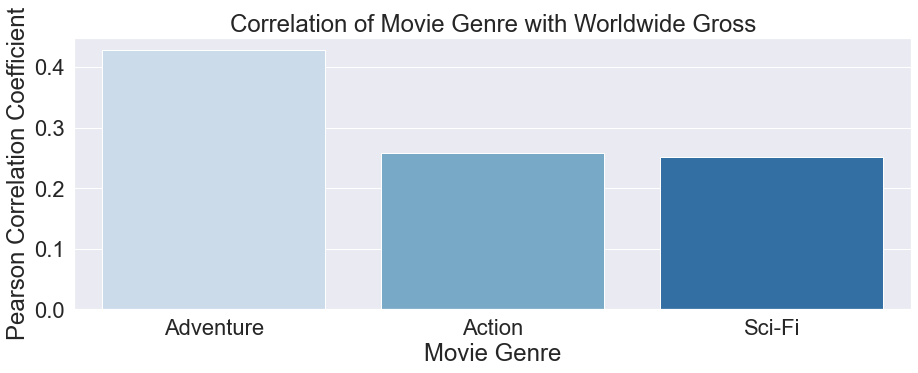

In [35]:
#Genre worldwide_gross Visualization
gen_gross = (correlation['worldwide_gross'].sort_values(ascending=False).filter(items=['Adventure', 'Action', 'Sci-Fi']))
gen_gross
ax = sns.barplot(x=gen_gross.index, y=gen_gross.values, palette ="Blues")
sns.set(rc = {'figure.figsize':(15,5)})
sns.set(font_scale = 2)
ax.set(xlabel='Movie Genre', ylabel='Pearson Correlation Coefficient', title='Correlation of Movie Genre with Worldwide Gross');


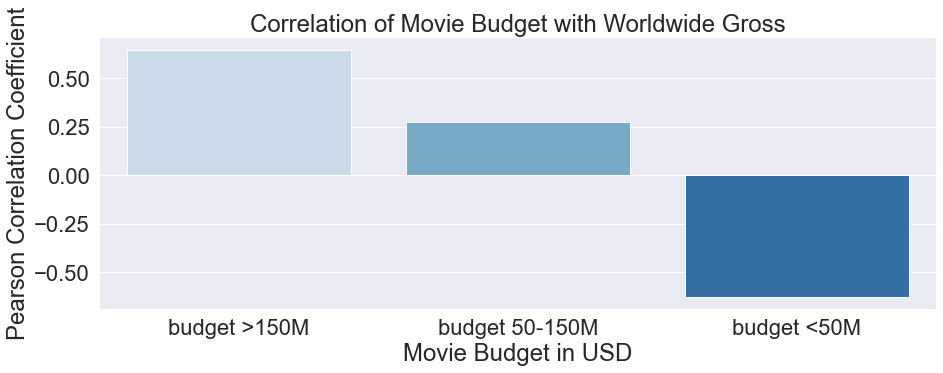

In [36]:
#Budget worldwide_gross Visualization
bud_gross = (correlation['worldwide_gross'].sort_values(ascending=False).filter(items=['budget >150M', 'budget 50-150M', 'budget <50M']))
bud_gross
ax = sns.barplot(x=bud_gross.index, y=bud_gross.values, palette ="Blues")
sns.set(rc = {'figure.figsize':(15,5)})
sns.set(font_scale = 2)
ax.set(xlabel='Movie Budget in USD', ylabel='Pearson Correlation Coefficient', title='Correlation of Movie Budget with Worldwide Gross');


In [18]:
#Top Genres for net_earnings
#Best budget for net_earnings
correlation = Genre_Budget.corr()
print(correlation['net_earnings'].sort_values(ascending=False).head(15))
print('Top Genres for net_earnings are Adventure, Sci-Fi, and Animation')
print('Best budget for net_earnings > $150Million')

net_earnings         1.000000
worldwide_gross      0.984593
domestic_gross       0.940625
production_budget    0.669944
budget >150M         0.571117
Adventure            0.364797
Sci-Fi               0.230535
Animation            0.228626
budget 50-150M       0.209728
Action               0.206355
runtime_minutes      0.199602
ROI                  0.156731
Fantasy              0.125282
Musical              0.094591
Family               0.059374
Name: net_earnings, dtype: float64
Top Genres for net_earnings are Adventure, Sci-Fi, and Animation
Best budget for net_earnings > $150Million


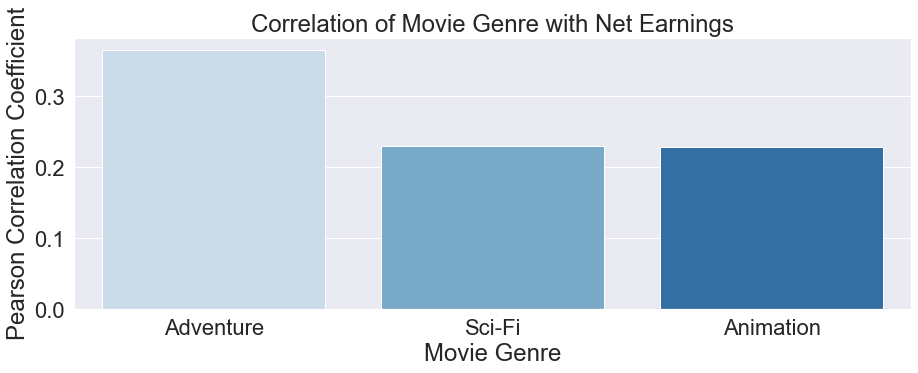

In [37]:
#Genre Net Earnings Visualization
gen_net_earnings = (correlation['net_earnings'].sort_values(ascending=False).filter(items=['Adventure', 'Sci-Fi', 'Animation']))
gen_net_earnings
ax = sns.barplot(x=gen_net_earnings.index, y=gen_net_earnings.values, palette ="Blues")
sns.set(rc = {'figure.figsize':(15,5)})
sns.set(font_scale = 2)
ax.set(xlabel='Movie Genre', ylabel='Pearson Correlation Coefficient', title='Correlation of Movie Genre with Net Earnings');


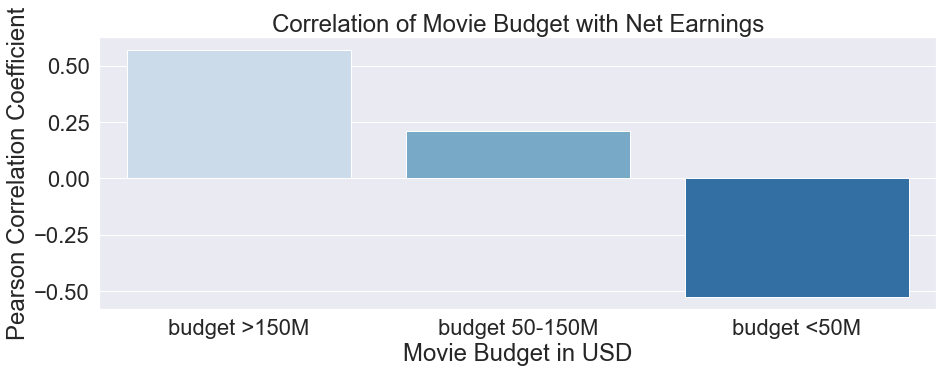

In [38]:
#Budget Net Earnings Visualization
bud_net = (correlation['net_earnings'].sort_values(ascending=False).filter(items=['budget >150M', 'budget 50-150M', 'budget <50M']))
bud_net
ax = sns.barplot(x=bud_net.index, y=bud_net.values, palette ="Blues")
sns.set(rc = {'figure.figsize':(15,5)})
sns.set(font_scale = 2)
ax.set(xlabel='Movie Budget in USD', ylabel='Pearson Correlation Coefficient', title='Correlation of Movie Budget with Net Earnings');


In [21]:
#Top Genres for ROI
#Best budget for ROI
correlation = Genre_Budget.corr()
print(correlation['ROI'].sort_values(ascending=False).head(12))
print('Top Genres for ROI are Horror, Mystery, and Thriller')
print('Best budget for ROI < $50Million')

ROI                1.000000
net_earnings       0.156731
domestic_gross     0.144408
Horror             0.140278
Mystery            0.140092
worldwide_gross    0.124728
Thriller           0.074936
budget <50M        0.017247
Romance            0.014999
Sport              0.012259
Animation          0.006562
Fantasy            0.006335
Name: ROI, dtype: float64
Top Genres for ROI are Horror, Mystery, and Thriller
Best budget for ROI < $50Million


In [22]:
#Top grossing movies
top_movie_gross = Genre_Budget.sort_values('worldwide_gross', ascending=False)
top_movie_gross.head()

,movie_id,Movie Title,runtime_minutes,release_date,production_budget,domestic_gross,worldwide_gross,net_earnings,ROI,budget <50M,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
1790,tt4154756,Avengers: Infinity War,149.0,2018-04-27,300000000,678815482,2048134200,1748134200,5.827114,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1198,tt0369610,Jurassic World,124.0,2015-06-12,215000000,652270625,1648854864,1433854864,6.669092,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1338,tt2820852,Furious 7,137.0,2015-04-03,190000000,353007020,1518722794,1328722794,6.993278,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17,tt0848228,The Avengers,143.0,2012-05-04,225000000,623279547,1517935897,1292935897,5.746382,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1301,tt2395427,Avengers: Age of Ultron,141.0,2015-05-01,330600000,459005868,1403013963,1072413963,3.243841,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Top earning movies
top_movie_net_earnings = Genre_Budget.sort_values('net_earnings', ascending=False)
top_movie_net_earnings.head()

,movie_id,Movie Title,runtime_minutes,release_date,production_budget,domestic_gross,worldwide_gross,net_earnings,ROI,budget <50M,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
1790,tt4154756,Avengers: Infinity War,149.0,2018-04-27,300000000,678815482,2048134200,1748134200,5.827114,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1198,tt0369610,Jurassic World,124.0,2015-06-12,215000000,652270625,1648854864,1433854864,6.669092,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1338,tt2820852,Furious 7,137.0,2015-04-03,190000000,353007020,1518722794,1328722794,6.993278,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17,tt0848228,The Avengers,143.0,2012-05-04,225000000,623279547,1517935897,1292935897,5.746382,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1770,tt1825683,Black Panther,134.0,2018-02-16,200000000,700059566,1348258224,1148258224,5.741291,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Top ROI movies
top_movie_ROI = Genre_Budget.sort_values('ROI', ascending=False)
top_movie_ROI.head()

,movie_id,Movie Title,runtime_minutes,release_date,production_budget,domestic_gross,worldwide_gross,net_earnings,ROI,budget <50M,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
1285,tt2309260,The Gallows,81.0,2015-07-10,100000,22764410,41656474,41556474,415.564740,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101,tt1560985,The Devil Inside,83.0,2012-01-06,1000000,53262945,101759490,100759490,100.759490,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1158,tt3713166,Unfriended,83.0,2015-04-17,1000000,32789645,64364198,63364198,63.364198,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1526,tt6147768,Split,123.0,2017-01-20,5000000,138141585,278964806,273964806,54.792961,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1521,tt2660118,Split,90.0,2017-01-20,5000000,138141585,278964806,273964806,54.792961,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


**Start of Personnel Section**

In [25]:
GB_People.drop(columns=['Movie Title_x', 'Movie Title_y', 'release_date', 'id'], inplace=True)
GB_People = GB_People.dropna(subset=['genres'])

In [26]:
GB_People.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16735 entries, 0 to 16824
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           16735 non-null  object 
 1   start_year         16735 non-null  int64  
 2   runtime_minutes    15868 non-null  float64
 3   genres             16735 non-null  object 
 4   movie              16735 non-null  object 
 5   production_budget  16735 non-null  int64  
 6   domestic_gross     16735 non-null  int64  
 7   worldwide_gross    16735 non-null  int64  
 8   net_earnings       16735 non-null  int64  
 9   ROI                16735 non-null  float64
 10  person_id          16735 non-null  object 
 11  category           16735 non-null  object 
 12  primary_name       16735 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 1.8+ MB


In [27]:
# DF of movies containing Adventure
adventure_df = GB_People
adventure_df = adventure_df[adventure_df['genres'].str.contains("Adventure")]

#Created Adventure acting list
adv_person_list = list(adventure_df['primary_name'])

#DF of all movies with financial data for adventure personnel
adv_person_fin_DF = GB_People[GB_People['primary_name'].isin(adv_person_list)]
adv_person_fin_DF

,movie_id,start_year,runtime_minutes,genres,movie,production_budget,domestic_gross,worldwide_gross,net_earnings,ROI,person_id,category,primary_name
10,tt0337692,2012,124.0,"Adventure,Drama,Romance",On the Road,25000000,720828,9313302,-15686698,-0.627468,nm0439768,producer,Nathanaël Karmitz
11,tt0337692,2012,124.0,"Adventure,Drama,Romance",On the Road,25000000,720828,9313302,-15686698,-0.627468,nm0727165,actor,Sam Riley
12,tt0337692,2012,124.0,"Adventure,Drama,Romance",On the Road,25000000,720828,9313302,-15686698,-0.627468,nm1330560,actor,Garrett Hedlund
13,tt0337692,2012,124.0,"Adventure,Drama,Romance",On the Road,25000000,720828,9313302,-15686698,-0.627468,nm0829576,actress,Kristen Stewart
14,tt0337692,2012,124.0,"Adventure,Drama,Romance",On the Road,25000000,720828,9313302,-15686698,-0.627468,nm0010736,actress,Amy Adams
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,tt7504726,2020,NaN,"Adventure,Animation,Family",Call of the Wild,82000000,0,0,-82000000,-1.000000,nm1405398,actor,Dan Stevens
16821,tt7504726,2020,NaN,"Adventure,Animation,Family",Call of the Wild,82000000,0,0,-82000000,-1.000000,nm0761498,director,Chris Sanders
16822,tt7504726,2020,NaN,"Adventure,Animation,Family",Call of the Wild,82000000,0,0,-82000000,-1.000000,nm0338169,writer,Michael Green
16823,tt7504726,2020,NaN,"Adventure,Animation,Family",Call of the Wild,82000000,0,0,-82000000,-1.000000,nm0831098,producer,Erwin Stoff


In [28]:
# Function that groups individuals by name, returning the mean and median of net earnings, then sorts by both (descending) 
import numpy as np
def ind_earn(data):
    temp_fin = data.groupby("primary_name").agg({"net_earnings": [np.mean, np.median]})
    temp_fin.reset_index(inplace=True)
    temp_fin.columns = ["Primary Name", "Mean Net Earnings", "Median Net Earnings"]
    temp_fin.sort_values(by=["Mean Net Earnings", "Median Net Earnings"], inplace = True, ascending = False)
    temp_fin.reset_index(drop=True, inplace=True)
    return temp_fin

In [29]:
# Fucntion takes a dataframe with 'category' and filters that column by a string
def jobs(data, job):
    tempdf = data[data['category'].str.contains(job)]
    return tempdf

In [30]:
# Create DF of people who act in adventure movies
advent_act = jobs(adventure_df, "actor|actress")

# Create table grouped by individual actor/actress showing their median and mean net earnings
indact_fin = ind_earn(advent_act)
indact_fin


,Primary Name,Mean Net Earnings,Median Net Earnings
0,Judy Greer,1.433855e+09,1.433855e+09
1,Ty Simpkins,1.433855e+09,1.433855e+09
2,Bryce Dallas Howard,1.284814e+09,1.284814e+09
3,Danai Gurira,1.148258e+09,1.148258e+09
4,Lupita Nyong'o,1.148258e+09,1.148258e+09
...,...,...,...
906,Seung-heon Song,-6.448372e+07,-6.448372e+07
907,William Wai-Ting Chan,-6.448372e+07,-6.448372e+07
908,Ye Liu,-6.448372e+07,-6.448372e+07
909,Dan Stevens,-8.200000e+07,-8.200000e+07


In [31]:
# Create DF of people who act in adventure movies
advent_act = jobs(adv_person_fin_DF, "actor|actress")

# Create table grouped by individual actor/actress showing their median and mean net earnings
indact_fin = ind_earn(advent_act)


In [32]:
#Top 10 acting
top10_acting = indact_fin.head(10)
top10_acting

,Primary Name,Mean Net Earnings,Median Net Earnings
0,Ty Simpkins,1.433855e+09,1.433855e+09
1,Rafe Spall,1.135773e+09,1.135773e+09
2,Idina Menzel,1.122470e+09,1.122470e+09
3,Jonathan Groff,1.122470e+09,1.122470e+09
4,Pierre Coffin,1.086336e+09,1.086336e+09
5,Craig T. Nelson,1.042521e+09,1.042521e+09
6,Huck Milner,1.042521e+09,1.042521e+09
7,Sarah Vowell,1.042521e+09,1.042521e+09
8,Robert Downey Jr.,9.643188e+08,1.015392e+09
9,Trey Parker,9.597278e+08,9.597278e+08


In [33]:
# Create table grouped by individual director showing their median and mean net earnings
advent_dir = jobs(adv_person_fin_DF, "director")
dir_fin = ind_earn(advent_dir)

In [34]:
#Top 10 directors
top10_dir = dir_fin.head(10)
top10_dir

,Primary Name,Mean Net Earnings,Median Net Earnings
0,Joss Whedon,1.182675e+09,1.182675e+09
1,Chris Buck,1.122470e+09,1.122470e+09
2,Jennifer Lee,1.122470e+09,1.122470e+09
3,Anthony Russo,1.060869e+09,8.900694e+08
4,Joe Russo,1.060869e+09,8.900694e+08
5,Kyle Balda,1.023032e+09,1.023032e+09
6,Eric Guillon,9.597278e+08,9.597278e+08
7,Anna Boden,9.480616e+08,9.480616e+08
8,Ryan Fleck,9.480616e+08,9.480616e+08
9,Pierre Coffin,9.294723e+08,9.294723e+08
